In [1]:
using Pkg
Pkg.activate(@__DIR__)
push!(LOAD_PATH, joinpath(@__DIR__, "..", ".."))
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %

In [61]:
using JuMP
using BARON
using LinearAlgebra
using StaticArrays
using MINLPTrajOpt
using MINLPTrajOpt.SO3
using Rotations
using Random

In [62]:
rootdir = joinpath(dirname(pathof(MINLPTrajOpt)), "..")
save_data = true;

In [63]:
solver = BaronSolver(threads=Sys.CPU_THREADS, EpsA=1e-2, MaxTime=10 * 60.0, PrTimeFreq=5.)
# solver = CouenneNLSolver()
parameters = SO3Parameters(Ixx = 1., Iyy = 0.7, Izz = 1.4)
τmax = 10.0
Random.seed!(1)
quat0 = rand(Quat)
ω0 = zero(SVector{3})

N = 15
T = 4.0
Δt = T / N
Δθmax = 0.5

problem = SO3Problem(parameters, quat0, ω0, solver; τmax=τmax, Δt=Δt, N=N, Δθmax=Δθmax);

In [64]:
status = solve(problem.model)
@assert status == :Optimal

 BARON version 18.8.23. Built: LNX-64 Thu Aug 23 14:46:44 EDT 2018

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: MIT at Twan Koolen, tkoolen@mit.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP: ILOG CPLEX                                      
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Using CPLEX library libcplex1280.so.
 Preprocessing found feasible solution with value  3.42981266142     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s) 

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /home/twan/.julia/packages/JuMP/Xvn0n/src/nlp.jl:1283


AssertionError: AssertionError: status == :Optimal

In [65]:
if save_data
    i = 0
    while (datadir = joinpath(rootdir, "data", "so3", "run$i"); isdir(datadir))
        i += 1
    end
    mkpath(datadir)
end
if save_data && solver isa BaronSolver
    cp(dirname(problem.model.internalModel.options[:SumName]), joinpath(datadir, "baronfiles"))
end

"/home/twan/code/julia-projects/MINLPTrajOpt/src/../data/so3/run0/baronfiles"

In [66]:
problem.model.internalModel.options[:SumName]

"/tmp/tmpjhCHpl/sum.lst"

In [67]:
t = range(0, T, length=N+1)
quats = getvalue.(problem.q)
pushfirst!(quats, problem.q0)
θs = map(rotation_angle, quats)
qs = [[quat.w, quat.x, quat.y, quat.z] for quat in quats]
Δquats = getvalue.(problem.Δq)
ωs = getvalue.(problem.ω)
ωds = getvalue.(problem.ωd)
τs = getvalue.(problem.τ);

In [68]:
using Test
for Δquat in Δquats
    Δθ = 2 * acos(Δquat.w)
    @show Δθ
    @test Δθ <= Δθmax + 1e-6
    @test norm([Δquat.w, Δquat.x, Δquat.y, Δquat.z]) ≈ 1 atol=1e-6
end

Δθ = 0.2598815165497173
Δθ = 0.3788110380414757
Δθ = 0.401062929939656
Δθ = 0.3652245762140158
Δθ = 0.3021981878390375
Δθ = 0.23292002794089933
Δθ = 0.16926214688468022
Δθ = 0.11654965404747339
Δθ = 0.07606194848361304
Δθ = 0.04691386667538001
Δθ = 0.027292885034983404
Δθ = 0.015197464562498061
Δθ = 0.008775469607533195
Δθ = 0.006168900599297764
Δθ = 0.005435149603111585


In [69]:
if save_data
    open(joinpath(datadir, "settings.txt"), write=true) do io
        println(io, "N = $N")
        println(io, "T = $T")
        println(io, "τmax = $τmax")
        println(io, "quat0 = $quat0")
        println(io, "ω0 = $ω0")
        println(io, "solver = $solver")
        println(io, "status = $status")
        println(io, "objective value = $(getobjectivevalue(problem.model))")
        println(io, "objective lower bound = $(getobjbound(problem.model))")
        println(io, "solvetime = $(getsolvetime(problem.model))")
        println(io)
    end
end

In [70]:
include(joinpath(rootdir, "extras", "plotting.jl"));

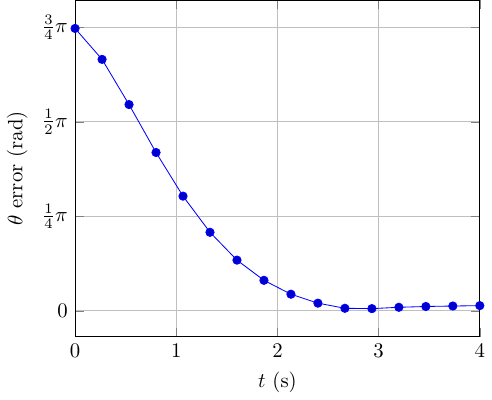

In [71]:
p = timeplot(t, θs; ylabel=L"$\theta$ error (rad)")
piticks!(p, 1//4, θs; axis=:y)
save_data && pgfsave(joinpath(datadir, "error.pdf"), p)
p

In [72]:
using RigidBodyDynamics

In [73]:
world = RigidBody{Float64}("world")
mechanism = Mechanism(world)
joint = Joint("joint", QuaternionSpherical{Float64}())
inertia = SpatialInertia(joint.frame_after, Diagonal([parameters.Ixx, parameters.Iyy, parameters.Izz]), zeros(3), 30.0)
body = RigidBody(inertia)
attach!(mechanism, world, body, joint);

In [74]:
using MeshCat, MeshCatMechanisms, MechanismGeometries

In [75]:
mvis = MechanismVisualizer(mechanism, Skeleton(inertias=true));
open(mvis)

┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8703
└ @ MeshCat /home/twan/.julia/packages/MeshCat/rjDJh/src/servers.jl:12
┌ Info: Listening on: Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 0x21ff)
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:307


Process(`xdg-open http://127.0.0.1:8703`, ProcessExited(0))

┌ Info: Accept:  🔗    0↑     0↓    0s 127.0.0.1:8703:8703 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:366
┌ Info: Accept:  🔗    0↑     0↓    0s 127.0.0.1:8703:8703 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:366
┌ Info: Accept:  🔗    0↑     0↓    0s 127.0.0.1:8703:8703 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:366


In [76]:
frame = frame_after(joint)
setobject!(mvis[frame]["triad"], Triad(0.5))

MeshCat Visualizer with path /meshcat/world/after_joint/after_joint/triad

In [77]:
setanimation!(mvis, t, qs)

In [78]:
normalize.(τs)

15-element Array{Array{Float64,1},1}:
 [-0.551195, 0.833232, 0.043683]  
 [-0.633697, 0.773575, 0.00303864]
 [-0.877274, 0.443378, -0.183864] 
 [0.26145, -0.949631, -0.172754]  
 [0.478599, -0.876032, -0.0592522]
 [0.54994, -0.835176, -0.00692099]
 [0.595225, -0.802894, 0.0326972] 
 [0.631902, -0.772107, 0.0674533] 
 [0.665062, -0.740021, 0.100305]  
 [0.696398, -0.705211, 0.133071]  
 [0.72623, -0.666813, 0.167184]   
 [0.754263, -0.624074, 0.204009]  
 [0.780018, -0.575665, 0.245321]  
 [0.803144, -0.517901, 0.294514]  
 [0.823189, -0.438748, 0.36036]   